In [1]:
import sys; sys.path.append('../')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import OrderedDict
from loss import compare_activations, get_bre_loss, get_gradmask_loss
import copy
import itertools
import logging
import notebooks.auto_ipynb as auto_ipynb
import numpy as np
import pprint
import random
import time, os, sys
import torch
import torch.nn as nn
import utils.configuration as configuration
import utils.monitoring as monitoring
import models, models.CNN, models.ResNetSmall, models.UNet
import matplotlib.pyplot as plt
import datasets, datasets.MSDDataset
import glob

In [3]:
import datasets, datasets.XRay

In [5]:
def render_img(text, i, sample, models_list, exp_name):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6,
                                             figsize=(18, 12), dpi=72)
    x, target, use_mask = sample
    #x = torch.tensor(x)
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
        requires_grad=True).float()
#     if torch.cuda.is_available():
#         x_var = x_var.cuda()
#         cnn = cnn.cuda()
#         resnet = resnet.cuda()
#         unet = unet.cuda()

    ax0.set_title(str(i) + " Masked Image")
    img = x[0][0].cpu().numpy()
    img = img / np.max(img)  # Scales the input image so that the maximum=1.
    seg = x[1][0].cpu().numpy() #* 0.5  # Makes mask bright, but not too bright.
    ax0.imshow(img, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(1-seg, cmap="Greys_r", interpolation='none')
    ax1.axis('off')

    ax2.set_title(models_list[0][0])
    this_model = models_list[0][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax2.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title(models_list[1][0])
    this_model = models_list[1][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax3.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title(models_list[2][0])
    this_model = models_list[2][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax4.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax4.axis('off')

    ax5.set_title("UNet Reconstruction")
    # Fails for models that output a nonsense reconstruction (CNN, ResNet).
    if isinstance(x_prime, torch.Tensor):
        ax5.imshow(x_prime[0][0].detach().cpu().numpy(),
                   interpolation='none', cmap='Greys_r')
        ax5.axis('off')
    else:
        ax5.remove()

    plt.tight_layout()
    plt.show()

In [29]:
args = {'d1data': '/lustre04/scratch/cohenjos/NIH/images-224', 
        'd1csv': '/lustre03/project/6008064/jpcohen/ChestXray-NIHCC/Data_Entry_2017.csv', 
        'd2data': '/lustre04/scratch/cohenjos/PC/images-224', 
        'd2csv': '/lustre03/project/6008064/jpcohen/PADCHEST_SJ/labels_csv/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv', 
        'mode': 'test', 
        'ratio': 0.5, 
        'nsamples': 500, 
        'maxmasks': 1.0}
d = datasets.XRay.JointDataset(**args)

n_per_category=2772
TRAIN: neg=2772, pos=2772
VALID: neg=1386, pos=1386
TEST: neg=1386, pos=1386


In [10]:
glob.glob("/home/jdv/code/activmask/activmask/checkpoints/*/*.tar")

['/home/jdv/code/activmask/activmask/checkpoints/xray_resnet/best_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet/best_model_0_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet/latest_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/test/best_model_0_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_actdiff/best_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_actdiff/latest_model_0_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_actdiff/best_model_0_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_actdiff/latest_model_1234_1.0.pth.tar']

In [7]:
glob.glob("/home/cohenjos/workspace/activmask/activmask/checkpoints/*/*.tar")

['/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_01_resnet/latest_model_0_1.0.pth.tar',
 '/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_01_resnet/best_model_0_1.0.pth.tar',
 '/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_01_resnet_gradmask/latest_model_0_1.0.pth.tar',
 '/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_01_resnet_gradmask/best_model_0_1.0.pth.tar']

In [8]:
# a= torch.load("/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_resnet/best_model_0_1.0.pth.tar", map_location='cpu')
# resnet = models.ResNetSmall.ResNetBig(base_size=25088)
# resnet.load_state_dict(a.state_dict())

In [9]:
# a= torch.load("/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_resnet_gradmask/best_model_0_1.0.pth.tar", map_location='cpu')
# gradmask = models.ResNetSmall.ResNetBig(base_size=25088)
# gradmask.load_state_dict(a.state_dict())

In [36]:
models_names_list = ["xray_resnet/latest","xray_resnet_actdiff/latest","xray_resnet_actdiff/latest"]
models_list = []
for m in models_names_list:
    a= torch.load("/home/jdv/code/activmask/activmask/checkpoints/{}_model_1234_1.0.pth.tar".format(m), map_location='cpu')
    #a= torch.load("/home/cohenjos/workspace/activmask/activmask/checkpoints/{}_model_0_1.0.pth.tar".format(m), map_location='cpu')
    resnet = models.ResNetSmall.ResNetBig(base_size=61952, img_size=112)
    resnet.load_state_dict(a.state_dict())
    models_list.append([m,resnet])
    

0


RuntimeError: size mismatch, m1: [1 x 4608], m2: [61952 x 2] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:752

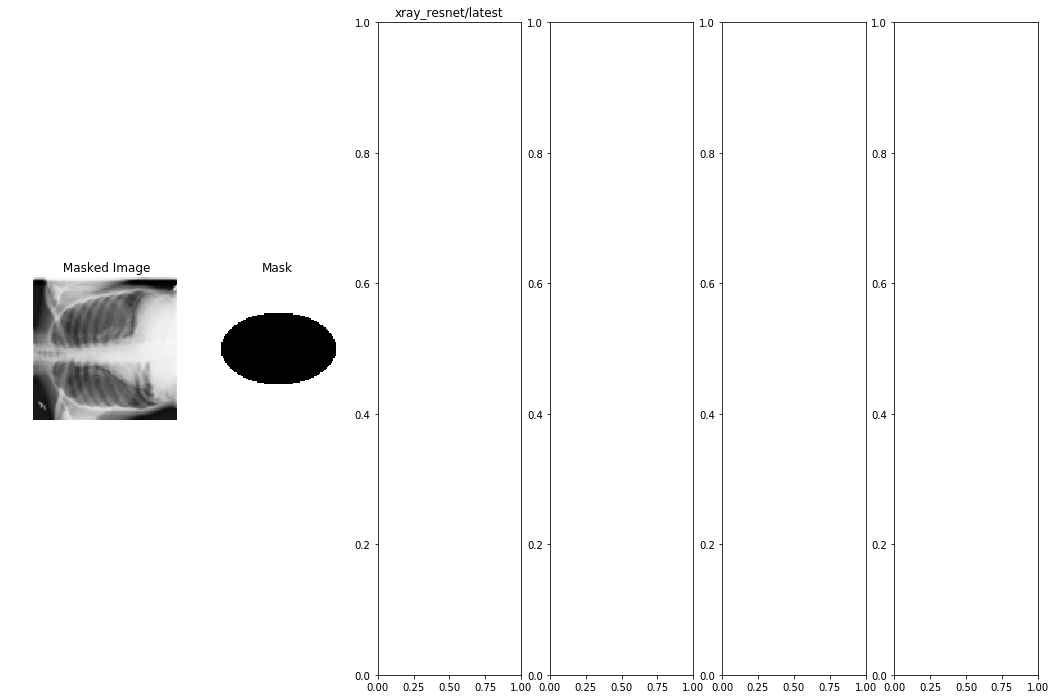

In [37]:
sample = d[100]
print(sample[1])
render_img("aaa", "", sample, models_list, "a")

In [38]:
resnet = models.ResNetSmall.ResNetBig(base_size=61952, img_size=112)

In [ ]:
resnet(torch.ones([1,1,300,300]))

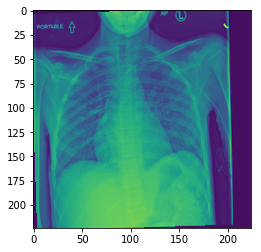

In [52]:
plt.imshow(new_img)

In [11]:
#torch.tensor(d[546][0])[1].shape

In [79]:
# x, target, use_mask = sample
# x = torch.tensor(x[0])
# x_var = torch.autograd.Variable(x.unsqueeze(0),
#     requires_grad=True)

# y_prime, x_prime = resnet(x_var)
# gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
#                              "contrast").detach().cpu().numpy()[0][0]

In [26]:
aa = []
for i in np.where(d.labels == 0)[0]:
    #print(d[i][0][0].mean(0).shape)
    
    x, target, use_mask = d[i]
    x = torch.tensor(x[0])
    x_var = torch.autograd.Variable(x.unsqueeze(0),
        requires_grad=True)
    
    if torch.cuda.is_available():
        x_var = x_var.cuda()
        resnet = resnet.cuda()

    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    
    aa.append(gradmask)

In [27]:
bb = []
for i in np.where(d.labels == 1)[0]:
    #print(d[i][0][0].mean(0).shape)
    
    x, target, use_mask = d[i]
    x = torch.tensor(x[0])
    x_var = torch.autograd.Variable(x.unsqueeze(0),
        requires_grad=True)
    
    if torch.cuda.is_available():
        x_var = x_var.cuda()
        resnet = resnet.cuda()

    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    
    bb.append(gradmask)

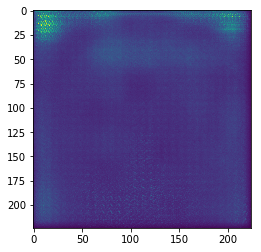

In [28]:
m1 = np.abs(np.asarray(aa)).mean(0)
plt.imshow(m1);

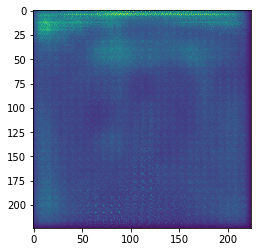

In [29]:
m2 = np.abs(np.asarray(bb)).mean(0)
plt.imshow(m2);